#**Setup**.
 
First import all needed libraries for the project.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
tf.__version__  # already checked and it gave one of the latest versions: 2.9.2
from tensorflow import keras
from keras import layers
from keras.models import Sequential 

# improting the dataset.

In this section the dataset meant for training will be uploaded from Google Drive.
so first we connect to the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


second, we unzip the file

In [ ]:
!unzip gdrive/My\the_path_of_the_training_file

third since we have successfully, we should check how many samples we have. 

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/train')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1156


Here are some dates:

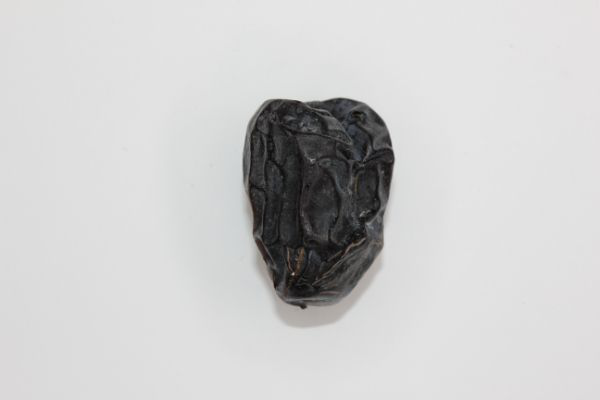

In [ ]:
dates = list(data_dir.glob('Ajwa/*'))
PIL.Image.open(str(dates[0]))

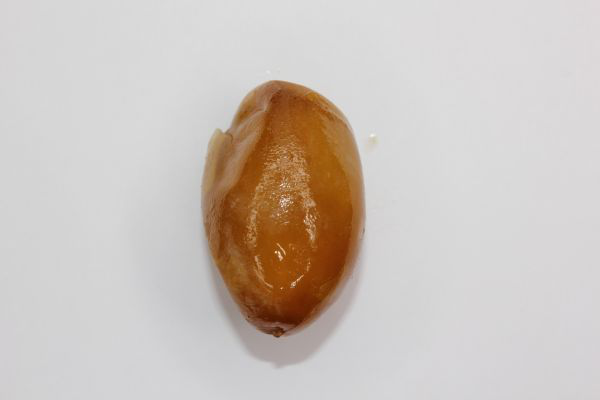

In [ ]:
dates = list(data_dir.glob('Rutab/*'))
PIL.Image.open(str(dates[0]))

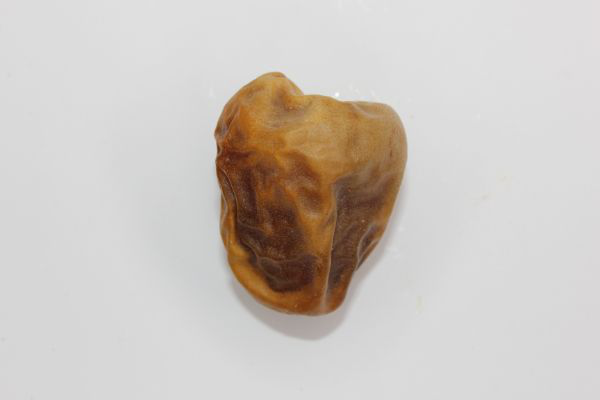

In [ ]:
dates = list(data_dir.glob('Sokari/*'))
PIL.Image.open(str(dates[0]))

# Chart visualization for samples counts per labels

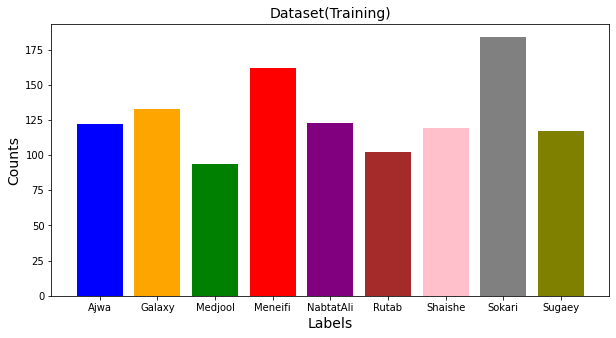

In [ ]:
# tried a number of approaches, yet none seemed to work, so I'll be using bruteforce
ajwa = len(list(data_dir.glob('Ajwa/*')))
galaxy = len(list(data_dir.glob('Galaxy/*')))
medjool = len(list(data_dir.glob('Medjool/*')))
meneifi = len(list(data_dir.glob('Meneifi/*')))
nabtatali = len(list(data_dir.glob('NabtatAli/*')))
rutab = len(list(data_dir.glob('Rutab/*')))
shaishe = len(list(data_dir.glob('Shaishe/*')))
sokari = len(list(data_dir.glob('Sokari/*')))
sugaey = len(list(data_dir.glob('Sugaey/*')))

y_axis = [ajwa, galaxy, medjool, meneifi, nabtatali, rutab, shaishe, sokari, sugaey] 
x_axis = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

# draw the bar chart
plt.figure(figsize = (10, 5))
colors = ['blue','orange', 'green', 'red','purple','brown','pink', 'grey', 'olive']
plt.bar(x_axis, y_axis, color=colors)
plt.title('Dataset(Training)', fontsize=14)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

# Data Preprocessing

First define some parameters that helps in the process

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Second divid the training set into:

1. training set.
2. validation set.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

# seed helps in organizing the examples,
# If we do not set the seed, then we get different random numbers at every invocation

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 9 classes.
Using 231 files for validation.


display the name of all of the classes.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


Now, visualize the data. Here are 3 images from the training set

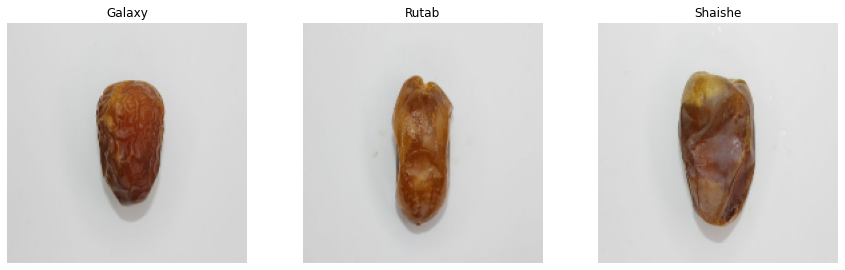

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

For a better performance there are 2 suggested methods, which are:

1. Dataset.cache.
2. Dataset.prefetch.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(925).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building the architecture of the model

I'll add these three architucture layers to help out more in the cnn:
- First: data augmentation.
- Second: data rescaling.
- Third: dropout



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# **Build the model**

In [ ]:
num_classes = len(class_names) # 9 classes
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax', name="outputs")
])

# the first hyperparameter is called units/filters and it controls the output dimensionality .

## Compile it

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

## Model summary

The function model.summary provides a summary of the built model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# **Train the model**

and to do that, simply use a built in function called Model.fit, and I'll train mine with 60 epochs

In [ ]:
epochs=60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
29/29 [==============================] - 46s 1s/step - loss: 2.1345 - accuracy: 0.1989 - val_loss: 1.8030 - val_accuracy: 0.2944
Epoch 2/60
29/29 [==============================] - 41s 1s/step - loss: 1.5154 - accuracy: 0.4227 - val_loss: 1.1332 - val_accuracy: 0.6840
Epoch 3/60
29/29 [==============================] - 40s 1s/step - loss: 1.0965 - accuracy: 0.6119 - val_loss: 0.8475 - val_accuracy: 0.7359
Epoch 4/60
29/29 [==============================] - 41s 1s/step - loss: 0.8620 - accuracy: 0.6919 - val_loss: 0.8148 - val_accuracy: 0.7143
Epoch 5/60
29/29 [==============================] - 40s 1s/step - loss: 0.7171 - accuracy: 0.7384 - val_loss: 0.6627 - val_accuracy: 0.7879
Epoch 6/60
29/29 [==============================] - 39s 1s/step - loss: 0.7349 - accuracy: 0.7362 - val_loss: 0.6127 - val_accuracy: 0.8139
Epoch 7/60
29/29 [==============================] - 38s 1s/step - loss: 0.6267 - accuracy: 0.8043 - val_loss: 0.4919 - val_accuracy: 0.8528
Epoch 8/60
29/29 [==

# visualize training results

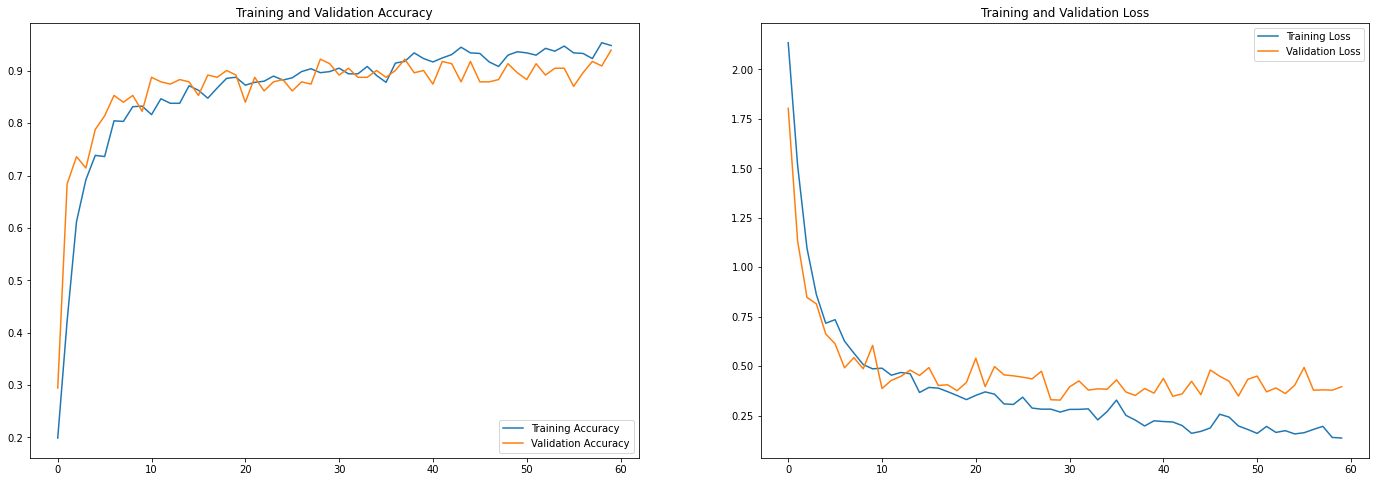

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Testing the model**

## Import the testing data

In [ ]:
!unzip gdrive/My\ the_path_of_test_data_set

Now to check how many images we have

In [ ]:
data_dirT = pathlib.Path('/content/test')
image_count_T = len(list(data_dirT.glob('*/*.jpg')))
print(image_count_T)

502


Let's view a couple of them.

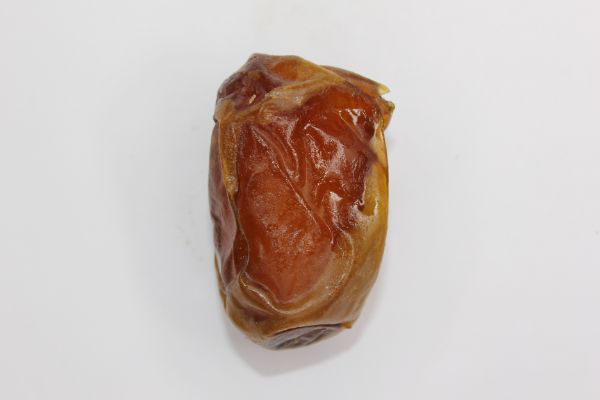

In [ ]:
dates_test = list(data_dirT.glob('Sugaey/*'))
PIL.Image.open(str(dates_test[0]))

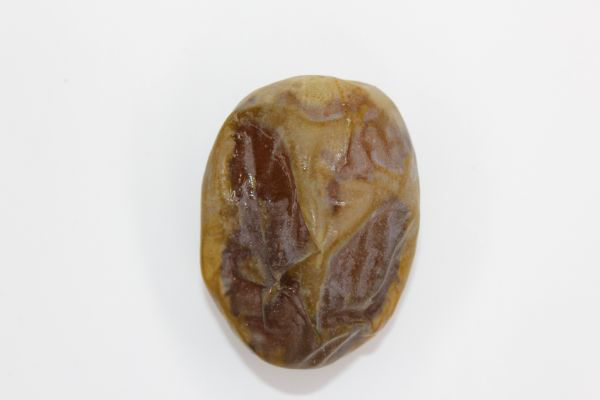

In [ ]:
dates_test = list(data_dirT.glob('Shaishe/*'))
PIL.Image.open(str(dates_test[0]))

# Visualize the testing test

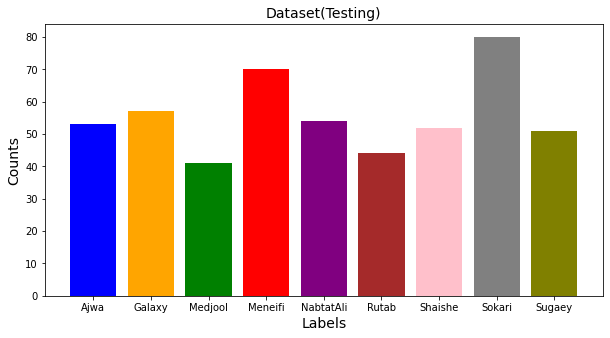

In [ ]:
ajwa = len(list(data_dirT.glob('Ajwa/*')))
galaxy = len(list(data_dirT.glob('Galaxy/*')))
medjool = len(list(data_dirT.glob('Medjool/*')))
meneifi = len(list(data_dirT.glob('Meneifi/*')))
nabtatali = len(list(data_dirT.glob('NabtatAli/*')))
rutab = len(list(data_dirT.glob('Rutab/*')))
shaishe = len(list(data_dirT.glob('Shaishe/*')))
sokari = len(list(data_dirT.glob('Sokari/*')))
sugaey = len(list(data_dirT.glob('Sugaey/*')))

y_axis = [ajwa, galaxy, medjool, meneifi, nabtatali, rutab, shaishe, sokari, sugaey] 
x_axis = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

# draw the bar chart
plt.figure(figsize = (10, 5))
colors = ['blue','orange', 'green', 'red','purple','brown','pink', 'grey', 'olive']
plt.bar(x_axis, y_axis, color=colors)
plt.title('Dataset(Testing)', fontsize=14)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

### put the testing images into a testing dataset

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dirT,
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 502 files belonging to 9 classes.


### calculate the model's accuracy and visulize its confusion matrix and classification report

16/16 [==============================] - 5s 284ms/step
Classification Accuracy :  0.898406374501992
Classification Report: 
              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        53
      Galaxy       0.89      0.88      0.88        57
     Medjool       0.97      0.90      0.94        41
     Meneifi       0.87      0.79      0.83        70
   NabtatAli       0.78      0.96      0.86        54
       Rutab       0.89      0.95      0.92        44
     Shaishe       0.98      0.90      0.94        52
      Sokari       0.88      0.93      0.90        80
      Sugaey       0.89      0.80      0.85        51

    accuracy                           0.90       502
   macro avg       0.91      0.90      0.90       502
weighted avg       0.90      0.90      0.90       502

Confusion Matrix: 


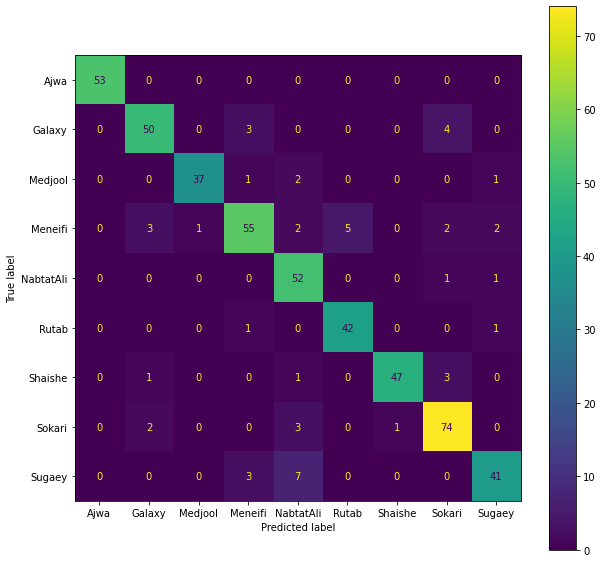

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

class_names = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']
images = []
labels = []
for image, label in test_ds:
  images.extend(image)
  labels.extend(label)
images = np.array(images)
labels = np.array(labels)

predictions = np.argmax(model.predict(images), axis=-1)

print("Classification Accuracy : ", accuracy_score(labels, predictions))

print("Classification Report: ")
print(classification_report(labels, predictions, target_names=class_names))


print("Confusion Matrix: ")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(labels, predictions), display_labels = class_names)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
